In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import datetime
#from torch.utils.tensorboard import SummaryWriter

W1120 14:22:19.539345 25140 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1120 14:22:19.556328 25140 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 50
np.random.seed(1)
torch.set_num_threads(4)

# Creating workers

In [3]:
def createClients(num_training, num_frauds):
    remote_dataset = tuple([list() for x in range((num_training + num_frauds))])
    models = []
    params = []
    optimizers = []
    compute_nodes = []
    frauds = []
    for i in range(num_training+num_frauds):
        m = Net().to(device)
        models.append(m)
        params.append(list(m.parameters()))
        optimizers.append(optim.SGD(m.parameters(), lr=0.1))
        
    for i in range(num_training):
        compute_nodes.append(sy.VirtualWorker(hook, id=("benign_" + str(i))))
    
    for i in range(num_frauds):
        frauds.append(sy.VirtualWorker(hook, id=("fraud_" + str(i))))
        
    return remote_dataset, models, params, optimizers, compute_nodes, frauds

# Helper function for dataset loader generation

In [4]:
#def generateLoadersPerClass(dataset):
#    #loaders per class
#    loaders_per_class = []
#    for class_name in dataset.classes:
#        # get the indices in the dataset that are relative to that class
#        idx = [
#            pos for pos, item in enumerate(dataset.samples)
#            if item[1] == dataset.class_to_idx[class_name]]
#        # construct the corresponding dataloader thanks to a SubsetRandomSampler
#        loaders_per_class += [torch.utils.data.DataLoader(
#            dataset, 
#            batch_size=batch_size,
#            sampler=SubsetRandomSampler(idx),
#            **kwargs)]
#    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])


#benign data
trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original',
                             transform=data_transform)
original_loader = torch.utils.data.DataLoader(trafficsign, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#original_loaders = generateLoadersPerClass(trafficsign)

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original_test',
                             transform=data_transform)

test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)


# Load backdoor dataset

In [6]:
#malicious data
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare',
                             transform=data_transform)
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
backdoored_loader = torch.utils.data.DataLoader(backdoored, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#backdoored_loaders = generateLoadersPerClass(backdoored)

#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare_test',
                             transform=data_transform)
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples] #set each image of backdoors to 001

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

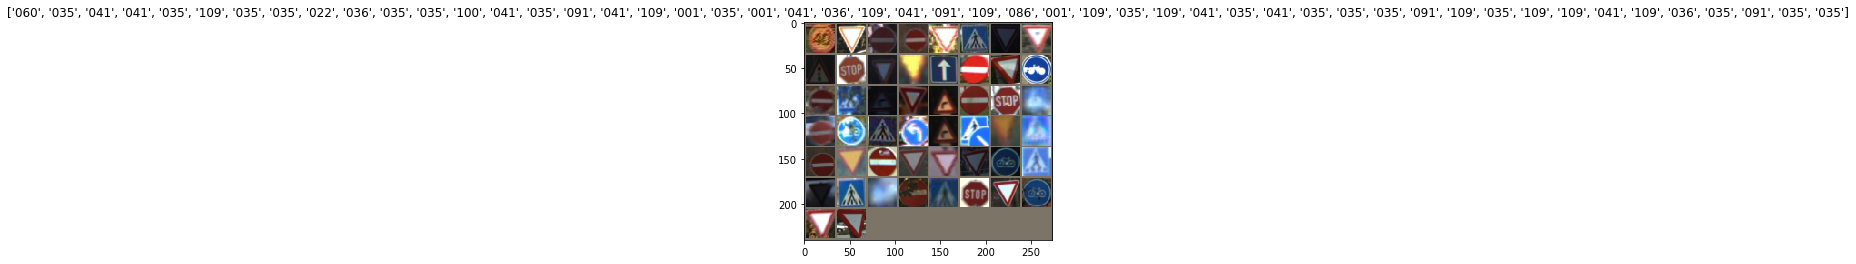

In [7]:
class_names = trafficsign.classes

#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(original_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf


# Secure Multiparty computation: send datasets to clients

In [9]:
def distributeDataToClients(num_training, num_frauds, percentagePoisonedData):
    global remote_dataset
    total_number_of_clients = num_training + num_frauds
    total_batches = 0
    #add original data
    for i, (d,t) in enumerate(original_loader): # run multiple times over the dataset to increase its size
        data = d.to(device)
        target = t.to(device)
        if(percentagePoisonedData == 1.0): #do not add original data to backdoor clients
            data = data.send(compute_nodes[i % num_training])
            target = target.send(compute_nodes[i % num_training])
            remote_dataset[i % num_training].append((data, target))
        else: #also add original data to backdoor clients (and remove after)
            targetClient = i % total_number_of_clients
            if (targetClient < num_training): #add to benign clients
                data = data.send(compute_nodes[targetClient])
                target = target.send(compute_nodes[targetClient])
            else: #add to malicious clients
                data = data.send(frauds[targetClient-num_training])
                target = target.send(frauds[targetClient-num_training])
            remote_dataset[targetClient].append((data, target))
        total_batches += 1
    

    if (num_frauds != 0):
    #add backdoor data
        all_backdoored_data = []
        for i, (d,t) in enumerate(train_loader):
            data = d.to(device)
            target = t.to(device)
            data = data.send(frauds[(i+1) % len(frauds)])
            target = target.send(frauds[(i+1) % len(frauds)])
            all_backdoored_data.append((data, target))
        
        
        #get subset of data to match with the number of benign and malicious nodes (100% backdoor, 0% benign data)
        total_data = total_batches * (len(compute_nodes) + len(frauds))/len(compute_nodes)
        fraction_of_backdoored_clients = len(frauds)/(len(compute_nodes) + len(frauds))
        shuffle(all_backdoored_data)
        all_backdoored_data = all_backdoored_data[:int(total_data*fraction_of_backdoored_clients)]
        
        
        #shorten benign data
        for i in range(num_frauds): 
            shuffle(remote_dataset[num_training+i])
            temp = list(remote_dataset)
            temp[num_training+i] = temp[num_training+i][:int((1-percentagePoisonedData) * len(temp[0]))]
            remote_dataset = tuple(temp)
            
        length = int((percentagePoisonedData) * len(temp[0]))
        #add each backdoor to remote_dataset
        for d,t in all_backdoored_data:
            if (length > 0): #only add percentage of backdoor data
                for i in range(num_frauds): #for each malicious client
                    remote_dataset[num_training + i].append((d, t)) # append new backdoored batch
            length -=1

In [10]:
hook = sy.TorchHook(torch)
percentagePoisonedData = 0
NO_BENIGN = 2
NO_FRAUDS = 0
remote_dataset, models, params, optimizers, compute_nodes, frauds = createClients(NO_BENIGN,NO_FRAUDS)
distributeDataToClients(NO_BENIGN,NO_FRAUDS,percentagePoisonedData)
modelReplacement = False


def update(data, target, model, optimizer):
    model.send(data.location)
    optimizer.zero_grad()
    pred = model(data)
    loss = F.cross_entropy(pred, target)
    losscopy = loss.copy().get()
    loss.backward()
    optimizer.step()
    return losscopy, model

#model replacement attack (see https://arxiv.org/pdf/1807.00459.pdf)
def update_poison(data, target, model, optimizer):
    global_model = model
    updated_Model = update(data, target, model, optimizer)
    
    clip_rate = (len(compute_nodes) + len(frauds)) #number_of_participants
    print(f"Scaling by  {clip_rate}")
    
    for key, value in updated_Model.state_dict().items():
        target_value = global_model.state_dict()[key]
        new_value = target_value + (value - target_value) * clip_rate
        updated_Model.state_dict()[key].copy_(new_value)
        
    return updated_Model

# Training Function

In [11]:
def trainSMPC(epoch, modelReplacement):
    minimumOfBatchesOverAllClients = min(map(len, remote_dataset))
    total_number_of_clients = int(len(compute_nodes) + len(frauds))
    mean_loss = 0
    for data_index in range(minimumOfBatchesOverAllClients): #iterates over batches
        print(f"update remote models {data_index+1} / {minimumOfBatchesOverAllClients}")
        for remote_index in range(total_number_of_clients): #each client of a batch
            d, t = remote_dataset[remote_index][data_index]
            data = d.to(device)
            target = t.to(device)
            
            #model replacement attack
            if(modelReplacement == True):
                if (remote_index > len(compute_nodes)):
                    models[remote_index] = update_poison(data, target, models[remote_index], optimizers[remote_index])
                else:
                    models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
            else:
                losscopy, model = update(data, target, models[remote_index], optimizers[remote_index])
                models[remote_index] = model
                mean_loss += losscopy
            
        #print(f"aggregation {data_index} / {minimumOfBatchesOverAllClients}")
        # encrypted aggregation
        new_params = list()
        for param_i in range(len(params[0])):
            spdz_params = list()
            for remote_index in range(total_number_of_clients):
                
                # select the identical parameter from each worker and copy it
                copy_of_parameter = (params[remote_index][param_i]).get()
                spdz_params.append(copy_of_parameter)
            
            new_param = sum(spdz_params)/total_number_of_clients
            new_params.append(new_param)
        
        #print(f"cleanup {data_index} / {minimumOfBatchesOverAllClients}")
        with torch.no_grad():
            for m in params:
                for param in m:
                    param *= 0

            for remote_index in range(total_number_of_clients):
                for param_index in range(len(params[remote_index])):
                    params[remote_index][param_index].data = new_params[param_index]
                    
        mean_loss = mean_loss/total_number_of_clients
        print(f"mean loss : {mean_loss}")

In [12]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            d, t = data.to(device), target.to(device)
            output = model(d)
            test_loss += F.cross_entropy(output, t, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [13]:
#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_traffic_"+dateString+".txt"),"w+")

#EXP-setup
csv_header = "#merge strategy: " + "smpc" + "\n"
csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(percentagePoisonedData*100) + "\n"
csv_header += "#way backdoor looks like: " + "green_squares" + "\n"
csv_header += "#order of time: " + "together" + "\n"
csv_header += "#attack model: " + ("model replacement" if modelReplacement else "basic") + "\n"
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 201):
    print(f"Epoch {epoch}")
    
    csv_normal = "normal;" + str(epoch) + ";" + str(0.01) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(0.01) + ";"

    
    #train both - set order in method
    avg_training_backdoor_loss = 0 #TODO
    trainSMPC(epoch, modelReplacement)
    csv_normal += str(avg_training_backdoor_loss) + ";"
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_combined = datetime.datetime.now().strftime("%H%M%S")
    
    #save after each 10 iterations
    if epoch % 2 == 0:
        torch.save(models[0].state_dict(), ("exp_traffic_"+dateString +"_epoch_" + str(epoch) + ".pt"))
    
    #test backdoor
    test_loss, acc = test(models[0], device, dataset_loader_backdoored_test, len(testdata))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(models[0], device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"
    
    #timestamps
    csv_normal += timestamp_combined + "\n"
    csv_backdoor += timestamp_combined + "\n"
    
    #Write to file
    f= open(("exp_traffic_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()


#merge strategy: smpc
#number of distributed sources: 2
#batch size: 50
#distribution of data: equally distributed subset
#percentage of backdoored nodes: 0.0
#percentage of poisoned data in backdoored nodes: 0
#way backdoor looks like: green_squares
#order of time: together
#attack model: basic
#starttime: 142228
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Epoch 1
update remote models 1 / 98
mean loss : 2.3062539100646973
update remote models 2 / 98
mean loss : 3.4509687423706055
update remote models 3 / 98
mean loss : 4.011322021484375
update remote models 4 / 98
mean loss : 4.288528919219971
update remote models 5 / 98
mean loss : 4.419811248779297
update remote models 6 / 98
mean loss : 4.472631454467773
update remote models 7 / 98
mean loss : 4.49452018737793
update remote models 8 / 98
mean loss : 4.489551544189453
update remote models 9 / 98
mean loss : 4.478702068328857
update remote models 10 / 98
mean loss : 4.474945545196533

update remote models 2 / 98
mean loss : 3.0533151626586914
update remote models 3 / 98
mean loss : 3.3414199352264404
update remote models 4 / 98
mean loss : 3.4782652854919434
update remote models 5 / 98
mean loss : 3.4157626628875732
update remote models 6 / 98
mean loss : 3.280179500579834
update remote models 7 / 98
mean loss : 3.0976834297180176
update remote models 8 / 98
mean loss : 2.785468101501465
update remote models 9 / 98
mean loss : 2.6812610626220703
update remote models 10 / 98
mean loss : 2.742865562438965
update remote models 11 / 98
mean loss : 2.590151309967041
update remote models 12 / 98
mean loss : 2.5795767307281494
update remote models 13 / 98
mean loss : 3.2835464477539062
update remote models 14 / 98
mean loss : 2.9173784255981445
update remote models 15 / 98
mean loss : 2.481956720352173
update remote models 16 / 98
mean loss : 2.3512825965881348
update remote models 17 / 98
mean loss : 2.151193141937256
update remote models 18 / 98
mean loss : 1.86818170547

         2.0000e+00, 9.1000e+01, 1.0000e+00, 5.5500e+02]])
tensor([0.9086, 0.8050, 0.9824, 0.9566, 0.8716, 0.9146, 0.9750, 0.9091, 0.5714,
        0.8552])
Epoch 3
update remote models 1 / 98
mean loss : 0.2875923216342926
update remote models 2 / 98
mean loss : 0.43396997451782227
update remote models 3 / 98
mean loss : 0.4733588397502899
update remote models 4 / 98
mean loss : 0.7122514247894287
update remote models 5 / 98
mean loss : 0.8674386143684387
update remote models 6 / 98
mean loss : 0.7305312156677246
update remote models 7 / 98
mean loss : 0.5614439845085144
update remote models 8 / 98
mean loss : 0.6002801656723022
update remote models 9 / 98
mean loss : 0.5277450084686279
update remote models 10 / 98
mean loss : 0.5710638761520386
update remote models 11 / 98
mean loss : 0.5970796942710876
update remote models 12 / 98
mean loss : 0.480681836605072
update remote models 13 / 98
mean loss : 0.5740590691566467
update remote models 14 / 98
mean loss : 0.5726690888404846
updat

         0.0000e+00, 1.1000e+01, 3.0000e+00, 6.3500e+02]])
tensor([0.9797, 0.7500, 0.9880, 0.9698, 0.9910, 0.9634, 0.9667, 0.9697, 0.9714,
        0.9784])
Epoch 4
update remote models 1 / 98
mean loss : 0.20705676078796387
update remote models 2 / 98
mean loss : 0.1828954815864563
update remote models 3 / 98
mean loss : 0.20244692265987396
update remote models 4 / 98
mean loss : 0.29979854822158813
update remote models 5 / 98
mean loss : 0.32901421189308167
update remote models 6 / 98
mean loss : 0.30860838294029236
update remote models 7 / 98
mean loss : 0.20558971166610718
update remote models 8 / 98
mean loss : 0.2032177597284317
update remote models 9 / 98
mean loss : 0.16523054242134094
update remote models 10 / 98
mean loss : 0.18029507994651794
update remote models 11 / 98
mean loss : 0.2802368700504303
update remote models 12 / 98
mean loss : 0.42496687173843384
update remote models 13 / 98
mean loss : 0.5699144601821899
update remote models 14 / 98
mean loss : 0.4945943355560

         1.0000e+00, 3.0000e+00, 3.0000e+00, 6.4000e+02]])
tensor([0.9949, 0.8250, 0.9917, 0.9849, 0.9932, 0.9878, 0.9833, 0.9508, 1.0000,
        0.9861])
Epoch 5
update remote models 1 / 98
mean loss : 0.16243617236614227
update remote models 2 / 98
mean loss : 0.126554474234581
update remote models 3 / 98
mean loss : 0.10946005582809448
update remote models 4 / 98
mean loss : 0.09489110857248306
update remote models 5 / 98
mean loss : 0.14639277756214142
update remote models 6 / 98
mean loss : 0.1731550097465515
update remote models 7 / 98
mean loss : 0.11243179440498352
update remote models 8 / 98
mean loss : 0.14550934731960297
update remote models 9 / 98
mean loss : 0.11564870923757553
update remote models 10 / 98
mean loss : 0.1318047195672989
update remote models 11 / 98
mean loss : 0.17121678590774536
update remote models 12 / 98
mean loss : 0.14641493558883667
update remote models 13 / 98
mean loss : 0.3188434839248657
update remote models 14 / 98
mean loss : 0.23231247067451

KeyboardInterrupt: 

In [ ]:
test(models[0], device, test_loader, len(testdata))